In [31]:
#import all required packages
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error

In [32]:
#data path
dpath='C:/Users/mhankins1/Documents/SofiaLegacyProgram/SOFIA_Cycle7_Data/SgrAandNearby'
dpathalt='E:\Documents\SofiaLegacyProgram\CAL_files\CAL_C'

#file name
fname='F0589_FO_IMA_07018929_FORF253_CAL_0080-0106_Field_R.fits'

#Name of field
field='FieldR'

#wavelength of data
wavelength=25.2

In [33]:
#change directory to data location
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(fname)
header=hdu[0].header
ims=hdu[0].data
#np.shape(ims)
data=ims[0]
varmap=ims[1]
tmap=ims[2]
#wcsmap = WCS(header)
hdu.close()

#hack to make SOFIA wcs header work correctly with astropy.wcs
hdu[0].header['NAXIS']=2
wcsmap=WCS(hdu[0].header)

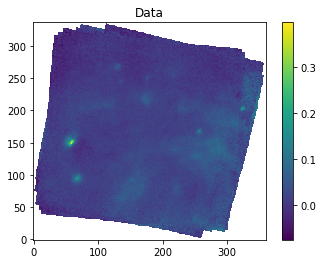

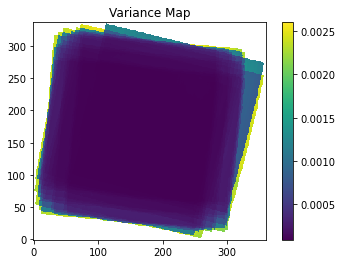

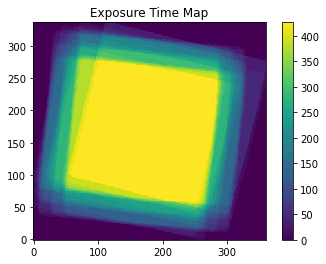

In [34]:
#take a quick look at the maps that were loaded in 
plt.figure()
plt.title('Data')
plt.imshow(data,origin='lower',interpolation='none')
plt.colorbar()
#plt.clim(0.0,0.1)
plt.show()

plt.figure()
plt.title('Variance Map')
plt.imshow(varmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Exposure Time Map')
plt.imshow(tmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

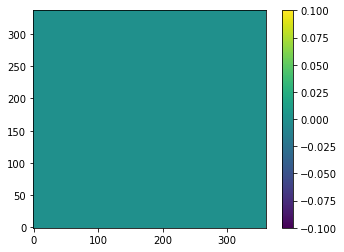

In [35]:
#create mask for edges of field where less integration time was collected
tmapnorm=tmap/np.max(tmap) #normalize the exposure time map
mask=np.where(tmapnorm<0.2,tmapnorm,0).astype('bool') #create mask for any locations with less than 50% of max exposure time -Can be modified as needed

#additional series of masks that can be applied when searching for sources in the segmentation map
mask2=np.zeros(np.shape(mask))  #mask 2 is applied to the first segmentation map instance for source detection
#mask2[350:380,0:370]=1
mask3=np.zeros(np.shape(mask))  #mask 3 is applied to the deblended segmentation map for source detection - this may or may not be needed if the first 2 masks work ok
#mask3[0:330,0:70]=1

#plot any of the masks to verify they are configured as needed
plt.figure()
plt.imshow(mask2,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

In [36]:
#create background model for image using median method
bkg_estimator = MedianBackground()
bkg_data = Background2D(data,(20, 20), filter_size=(3, 3),bkg_estimator=bkg_estimator,edge_method='pad') #smaller box?, 20x20, 25x25?
bkg_rms=bkg_data.background_rms
bkg=bkg_data.background 

#create background subtracted image
data_bkgsub = data - bkg

#set detection threshold for source finding based on modeled background rms
threshold = 3.0*bkg_rms

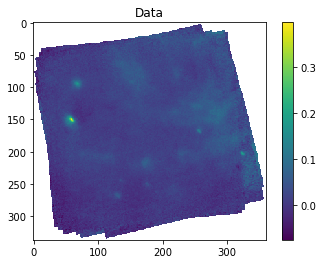

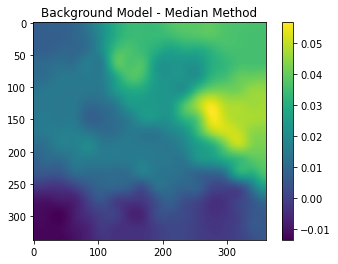

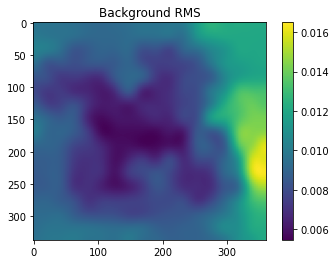

In [37]:
#take a look at data and bakground model images
plt.figure()
plt.title('Data')
plt.imshow(data,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background Model - Median Method')
plt.imshow(bkg,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background RMS')
plt.imshow(bkg_rms,interpolation='none')
plt.colorbar()
plt.show()

In [38]:
#do source detection. A 3x3 FWHM gaussian is used to smooth image prior to detection
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data_bkgsub, threshold, mask=mask, npixels=5, filter_kernel=kernel)

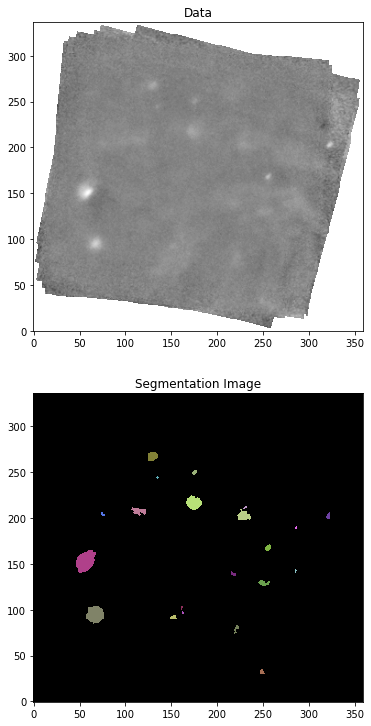

In [39]:
#removed labels that exist in masked region (mask2)
segm.remove_masked_labels(mask2.astype('bool'))

#make plot of segmentation image to show detected sources
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data_bkgsub, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap, interpolation='nearest')
ax2.set_title('Segmentation Image')
plt.show()

In [40]:
#now lets look at building a catalog and associated table from the seg map
cat = SourceCatalog(data_bkgsub, segm,background=bkg,wcs=wcsmap) #can also take in error and bkg measurements - this is done later

#specify the columns that we want for our table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl = cat.to_table(columns)

#display table below
tbl

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,249.49595337849937,32.1647463622235,"266.48440522152606,-28.78281505243093",-0.0012004525972263219,0.03349911761944197,0.7369805876277233,22.0,1.5991238533780956,1.1143482272992207,-82.98304806946572,0.7991186816294533,0.10045340788573753,0.39723530641740407,0.7172176443939051,0.3031507691257326,1.4350306432072824,3.2454550990537334,5.382717520820495,nan,3.400350843031384,0.842030062887833,nan
2,221.12161408996644,79.11222955318722,"266.49131334125815,-28.77280063828449",0.014023670186079112,0.02317771774058273,0.7648646854392301,33.0,2.7838381038715236,1.140207210802153,67.86965870128307,0.6783413623128915,-0.44677712168341016,0.219882863753835,0.9122737525649732,0.5904189941159113,2.4415194690034028,5.009136500277674,4.595840719251507,nan,3.12536458056586,0.8282511062391985,nan
3,67.56212488134925,94.76935333545619,"266.52868637930226,-28.769460018745292",0.014618419010412768,0.014824405457950574,4.373199610095419,295.0,4.083565572286667,3.992285149175283,25.9082105138716,0.06049769238126135,-0.0021801437938052132,0.06221228484776597,0.21025359478985628,0.02235311800326245,1.0228642042591172,9.509194946336606,19.582747684903367,nan,1.499117102882086,16.293045492786966,nan
4,152.69507000602835,91.80737678878275,"266.507967173826,-28.770093417759647",0.008404483329775753,0.03495360122442937,0.8738400306107343,25.0,1.768176498971947,1.1124636566607753,21.258275578265465,0.3840273729652927,-0.32991345304179975,0.7438559905736722,0.7772768550756738,0.3708412834874891,1.5894240574828224,3.478454023285748,6.718573574431028,nan,3.48039262228002,0.7915881198344886,nan
5,163.34724458069982,96.73265424304789,"266.50537471921115,-28.769042658556774",0.01075799334884652,0.03224938428882989,0.16124692144414945,5.0,0.7288625506856606,0.44968116630558497,-74.18017930955254,4.7176491726412015,1.6067160342083482,2.110013783345056,0.7869922219763352,0.38303708170689,1.62084295562949,1.426031433227123,1.4068843952455303,nan,3.726782928809957,0.14857410309293703,nan
6,161.99028648248628,102.22702582382458,"266.5057049976548,-28.76787053308278",0.010396044240201806,0.030134100048373823,0.33147510053211204,11.0,1.2181718003328648,0.691976240303036,72.36748890602097,1.9586281650601833,-0.8166969059984688,0.803671371109137,0.822997586393726,0.43195513135835695,1.7604243171693192,2.3328017688165383,3.1574873337565212,nan,3.623967554583527,0.29442617012566574,nan
7,251.65212973319754,129.47609968478457,"266.48388527502266,-28.76205520841326",0.00991904285941311,0.04569138931691313,2.147495297894917,47.0,3.3314337198064026,1.3452793248791153,-1.8735216459949582,0.09059695914618165,0.030221978937345458,0.5520601369875341,0.9148411415725995,0.5961860754182158,2.476388106318188,5.982407948122086,7.520482998320782,nan,3.1074218431873257,1.3643741102953333,nan
8,218.08398206258232,138.84640824383882,"266.4920546453769,-28.76005743951634",0.01398848504751163,0.02719253327821237,0.6526207986770969,24.0,1.7732776841895057,1.0932514981196384,-24.263242273249883,0.4055978607781715,0.38861719436415626,0.7490971987697952,0.7873435123383627,0.3834854473909878,1.6220217280648535,3.4687516726419365,5.275098838705867,nan,3.5661891818997216,0.6255306277872223,nan


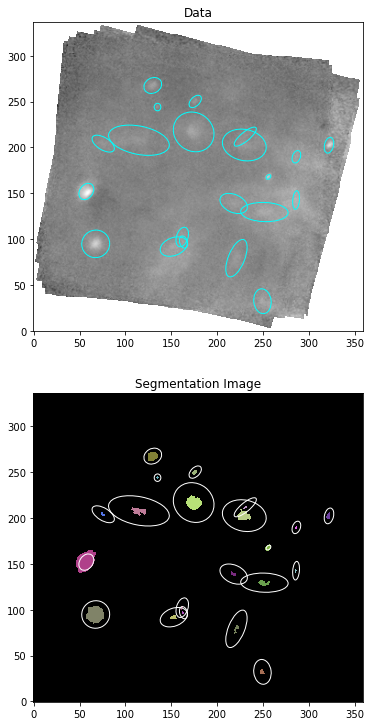

In [41]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in cat.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

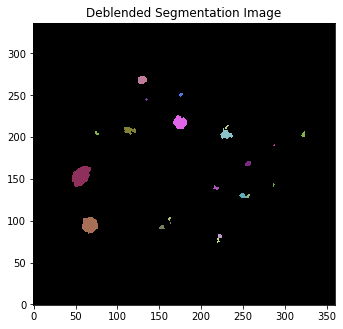

In [42]:
#lets take a look at deblending sources
segm_deblend = deblend_sources(data_bkgsub, segm, npixels=5,filter_kernel=kernel, nlevels=64,contrast=0.001)

#remove any sources that should be masked (mask3)
segm_deblend.remove_masked_labels(mask3.astype('bool'))

#plot the deblended image
plt.figure(figsize=(5.4, 8.5))
plt.imshow(segm_deblend, origin='lower', cmap=cmap, interpolation='nearest')
plt.title('Deblended Segmentation Image')
plt.show()

In [43]:
#now lets look at building a catalog and table from the deblended seg map
catde = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,wcs=wcsmap)

#define which columns we want to have in the table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl_deblend = catde.to_table(columns)

#display table
tbl_deblend

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,249.49595337849937,32.1647463622235,"266.48440522152606,-28.78281505243093",-0.0012004525972263219,0.03349911761944197,0.7369805876277233,22.0,1.5991238533780956,1.1143482272992207,-82.98304806946572,0.7991186816294533,0.10045340788573753,0.39723530641740407,0.7172176443939051,0.3031507691257326,1.4350306432072824,3.2454550990537334,5.382717520820495,nan,3.400350843031384,0.842030062887833,nan
2,67.56212488134925,94.76935333545619,"266.52868637930226,-28.769460018745292",0.014618419010412768,0.014824405457950574,4.373199610095419,295.0,4.083565572286667,3.992285149175283,25.9082105138716,0.06049769238126135,-0.0021801437938052132,0.06221228484776597,0.21025359478985628,0.02235311800326245,1.0228642042591172,9.509194946336606,19.582747684903367,nan,1.499117102882086,16.293045492786966,nan
3,152.69507000602835,91.80737678878275,"266.507967173826,-28.770093417759647",0.008404483329775753,0.03495360122442937,0.8738400306107343,25.0,1.768176498971947,1.1124636566607753,21.258275578265465,0.3840273729652927,-0.32991345304179975,0.7438559905736722,0.7772768550756738,0.3708412834874891,1.5894240574828224,3.478454023285748,6.718573574431028,nan,3.48039262228002,0.7915881198344886,nan
4,163.34724458069982,96.73265424304789,"266.50537471921115,-28.769042658556774",0.01075799334884652,0.03224938428882989,0.16124692144414945,5.0,0.7288625506856606,0.44968116630558497,-74.18017930955254,4.7176491726412015,1.6067160342083482,2.110013783345056,0.7869922219763352,0.38303708170689,1.62084295562949,1.426031433227123,1.4068843952455303,nan,3.726782928809957,0.14857410309293703,nan
5,161.99028648248628,102.22702582382458,"266.5057049976548,-28.76787053308278",0.010396044240201806,0.030134100048373823,0.33147510053211204,11.0,1.2181718003328648,0.691976240303036,72.36748890602097,1.9586281650601833,-0.8166969059984688,0.803671371109137,0.822997586393726,0.43195513135835695,1.7604243171693192,2.3328017688165383,3.1574873337565212,nan,3.623967554583527,0.29442617012566574,nan
6,218.08398206258232,138.84640824383882,"266.4920546453769,-28.76005743951634",0.01398848504751163,0.02719253327821237,0.6526207986770969,24.0,1.7732776841895057,1.0932514981196384,-24.263242273249883,0.4055978607781715,0.38861719436415626,0.7490971987697952,0.7873435123383627,0.3834854473909878,1.6220217280648535,3.4687516726419365,5.275098838705867,nan,3.5661891818997216,0.6255306277872223,nan
7,57.332320735598785,151.90510501802893,"266.5311733987022,-28.757270665712046",0.03648192972960276,0.01533630015870255,5.919811861259184,386.0,5.187368643250487,3.846326071965332,54.23386019558192,0.05719813780593133,-0.028864226684288296,0.04755838149694934,0.670975827870692,0.258520776816208,1.3486554561922337,10.752921302538486,28.230671369740076,nan,0.7476813135071049,34.83713650550202,nan
8,286.1850594036657,142.55812666341535,"266.4754823126212,-28.75926259838464",-0.0040534711154245244,0.054657604557172924,0.2732880227858646,5.0,1.057776620749661,0.37934830922574836,85.17173516798582,6.906123548768216,-1.015721667612333,0.9366403819605092,0.9334805626347262,0.6413720044626257,2.788404732602046,1.8711534911352046,3.271621527068766,nan,3.846358003535107,0.1982552445834057,nan


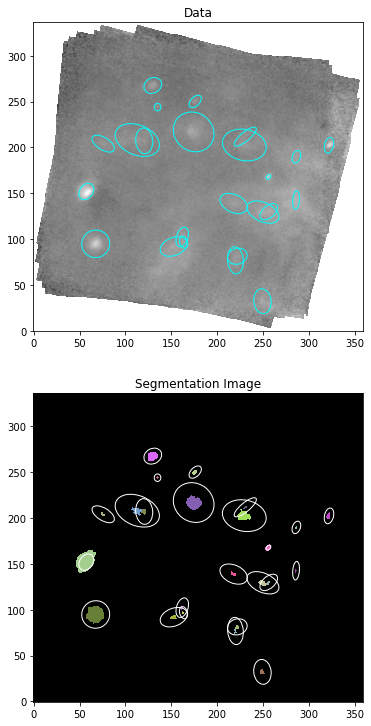

In [44]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm_deblend.make_cmap(seed=123)
ax2.imshow(segm_deblend, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in catde.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

In [45]:
#what if we wanted to include errors? - Not completely sure this is implemented correctly for our observations, but we'll use it for now...
calfactor = header['CALFCTR'] # units are (Me/sec/Jy)
gainfactor=tmap*calfactor*1e6 #gain in electrons/Jy
#errormap=calc_total_error(data,bkg,gainfactor) #use the varmap instead. Its probably more appropriate for our data type. 

#now lets look at building a catalog from the seg map
catwerr = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,error=errormap,wcs=wcsmap)
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','background','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']#,'kron_aperture']
tbl2 = catwerr.to_table(columns)

In [46]:
#calculate statistics for background cutouts in table
segbkg_median=[]
segbkg_mean=[]
segbkg_std=[]

#loop through each cutout and use sigma_cliped_stats to get mean, median, and std
for i in range (0,len(tbl2['background'])):
    bkgdata=tbl2['background'][i]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(bkgdata)
    segbkg_median.append(median_sigclip)
    segbkg_mean.append(meansc)
    segbkg_std.append(stdsc)

#add the above calculated information to our table
tbl2['segbkg_mean_sc']=segbkg_mean
tbl2['segbkg_median_sc']=segbkg_median
tbl2['segbkg_std_sc']=segbkg_std  

#remove the 2d background array to tidy up the table
tbl2.remove_column('background')

In [47]:
#calculate noise stats
#sky noise from background
skynoise=np.sqrt(tbl2['segbkg_median_sc']*tbl2['area']/u.pix**2)
#replace any nan values with zero
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#shot noise from the source
sourcenoise=tbl2['segment_flux']

#thermal noise from camera (from error map)
thermalnoise=tbl2['segment_fluxerr']

#total noise
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #includes all noise sources
totalnoise=np.sqrt(thermalnoise+skynoise) #no shot noise -> For some reason this seems to work much better for the apertures. Need to think about why this is a bit more...

#calculate SNR for the segments
tbl2['segmentSNR']=tbl2['segment_flux']/ totalnoise 

#display table
tbl2

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64
1,249.49595337849937,32.1647463622235,"266.48440522152606,-28.78281505243093",-0.0012004525972263219,0.03349911761944197,0.7369805876277233,22.0,1.5991238533780956,1.1143482272992207,-82.98304806946572,0.7991186816294533,0.10045340788573753,0.39723530641740407,0.7172176443939051,0.3031507691257326,1.4350306432072824,3.2454550990537334,5.382717520820495,0.3106544127355583,3.400350843031384,0.842030062887833,0.07409549,0.033349586921097046,0.033361853400235314,0.0007332342754679324,0.9367135383478371
2,67.56212488134925,94.76935333545619,"266.52868637930226,-28.769460018745292",0.014618419010412768,0.014824405457950574,4.373199610095419,295.0,4.083565572286667,3.992285149175283,25.9082105138716,0.06049769238126135,-0.0021801437938052132,0.06221228484776597,0.21025359478985628,0.02235311800326245,1.0228642042591172,9.509194946336606,19.582747684903367,0.27330953993553314,1.499117102882086,16.293045492786966,0.1734286,0.014821113622602928,0.014825842787540622,8.608357559280876e-05,7.640773034113178
3,152.69507000602835,91.80737678878275,"266.507967173826,-28.770093417759647",0.008404483329775753,0.03495360122442937,0.8738400306107343,25.0,1.768176498971947,1.1124636566607753,21.258275578265465,0.3840273729652927,-0.32991345304179975,0.7438559905736722,0.7772768550756738,0.3708412834874891,1.5894240574828224,3.478454023285748,6.718573574431028,0.20929314193728155,3.48039262228002,0.7915881198344886,0.04833899,0.034885074810953716,0.03495483950028827,0.0006241358896061852,0.824298214702267
4,163.34724458069982,96.73265424304789,"266.50537471921115,-28.769042658556774",0.01075799334884652,0.03224938428882989,0.16124692144414945,5.0,0.7288625506856606,0.44968116630558497,-74.18017930955254,4.7176491726412015,1.6067160342083482,2.110013783345056,0.7869922219763352,0.38303708170689,1.62084295562949,1.426031433227123,1.4068843952455303,0.09142475882950145,3.726782928809957,0.14857410309293703,0.021640003,0.032151463719092145,0.03215137086581074,0.00035079879283670643,0.3478839895293436
5,161.99028648248628,102.22702582382458,"266.5057049976548,-28.76787053308278",0.010396044240201806,0.030134100048373823,0.33147510053211204,11.0,1.2181718003328648,0.691976240303036,72.36748890602097,1.9586281650601833,-0.8166969059984688,0.803671371109137,0.822997586393726,0.43195513135835695,1.7604243171693192,2.3328017688165383,3.1574873337565212,0.1424410584100968,3.623967554583527,0.29442617012566574,0.03201536,0.030243543221207723,0.03023616400627748,0.0005714886890601769,0.4875961153566507
6,218.08398206258232,138.84640824383882,"266.4920546453769,-28.76005743951634",0.01398848504751163,0.02719253327821237,0.6526207986770969,24.0,1.7732776841895057,1.0932514981196384,-24.263242273249883,0.4055978607781715,0.38861719436415626,0.7490971987697952,0.7873435123383627,0.3834854473909878,1.6220217280648535,3.4687516726419365,5.275098838705867,0.21300463676602527,3.5661891818997216,0.6255306277872223,0.047403887,0.027110501323923723,0.027087799286832845,0.0011146167199339058,0.7489848387796137
7,57.332320735598785,151.90510501802893,"266.5311733987022,-28.757270665712046",0.03648192972960276,0.01533630015870255,5.919811861259184,386.0,5.187368643250487,3.846326071965332,54.23386019558192,0.05719813780593133,-0.028864226684288296,0.04755838149694934,0.670975827870692,0.258520776816208,1.3486554561922337,10.752921302538486,28.230671369740076,0.16807676391970935,0.7

In [48]:
#now lets look at performing some aperture photometry on the data.... Lets get the source centroids from the segmentaion map table
sourcecoords=tbl2['sky_centroid']

In [49]:
#first let's do some simple annulus extractions...   
radii = [2,4,6,8,10] #define aperture radii & construct apertures (line below)
apertures =[SkyCircularAperture(sourcecoords, r=r*u.arcsec) for r in radii] # for pixels: r=r*u.arcsec*0.786

#do aperture photometry on data using defined apertures 
phot_table = aperture_photometry(data_bkgsub, apertures,wcs=wcsmap,error=errormap,method='exact')

#display phot table
phot_table

id,xcenter,ycenter,sky_center,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,aperture_sum_2,aperture_sum_err_2,aperture_sum_3,aperture_sum_err_3,aperture_sum_4,aperture_sum_err_4
,pix,pix,"deg,deg",,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,249.4959533786103,32.16474636219064,"266.48440522152606,-28.78281505243093",0.7775265892388735,0.07274304189494794,2.0718882713697453,0.1421207698670302,3.5884723325320906,0.2128893457581829,5.192331001554781,0.2847548441811305,6.597943164364866,0.36027641878349903
2,67.56212488131332,94.76935333541745,"266.52868637930226,-28.769460018745292",2.832345219174312,0.04688710060080255,8.367497862139585,0.093522039078318,13.488642776263395,0.13986849023363865,17.040039059971054,0.18653690669634976,18.9632030633471,0.23387440094206427
3,152.6950700060472,91.80737678879288,"266.507967173826,-28.770093417759647",0.6760048700482627,0.04461157068605511,2.003123275497793,0.0893127530450455,3.4844379168254074,0.13397917534640819,5.1589535874719346,0.1786534164283029,7.631640486358939,0.2232833876438952
4,163.3472445807788,96.73265424299233,"266.50537471921115,-28.769042658556774",0.449115053807253,0.04464734256490907,1.3929149500068079,0.08926016123796464,3.0475911769870265,0.13388823317956575,5.431129455841939,0.178460500254,8.023829034560285,0.22307999717883667
5,161.99028648247588,102.2270258238392,"266.5057049976548,-28.76787053308278",0.49737523274222456,0.04459576427923837,1.5059720852097969,0.08922294445919156,2.8910938160999233,0.13378766027938713,4.559035850240262,0.17837281514925757,6.584378039414419,0.22293008242321627
6,218.0839820626477,138.84640824383317,"266.4920546453769,-28.76005743951634",0.5518639427626431,0.044660810272674586,1.7475527347432063,0.08935853634789022,3.1484200589563085,0.1340579404779871,4.337198001316243,0.1787398198450293,5.346175144461921,0.22342623706897025
7,57.332320735530374,151.90510501798016,"266.5311733987022,-28.757270665712046",4.909327326696869,0.053075738460936744,16.618161933855053,0.1053627880318283,26.524773837207952,0.15727777690513528,32.56105094522316,0.20920716532673744,35.46569265239182,0.2605927156227749
8,286.1850594035411,142.55812666343522,"266.4754823126212,-28.75926259838464",0.7437160082370139,0.05603686202997579,2.465480596372094,0.11374646325724512,5.11959902716457,0.17390726791534125,8.158283742245068,0.23578449968450702,11.315364974325696,0.2996748955443003


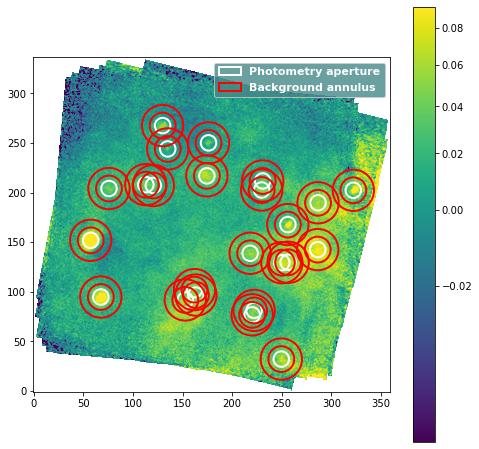

In [50]:
#now try photometry with local background subtraction
aperture2 =SkyCircularAperture(sourcecoords, r=6*u.arcsec) #define aperture
annulus_aperture = SkyCircularAnnulus(sourcecoords, r_in=10*u.arcsec, r_out=16*u.arcsec) #define annulus

#convert to pixel coords for plotting
pix_aperture = aperture2.to_pixel(wcsmap)
pix_annulus_aperture = annulus_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)

ap_patches = pix_aperture.plot(color='white', lw=2,
                           label='Photometry aperture')
ann_patches = pix_annulus_aperture.plot(color='red', lw=2,
                                    label='Background annulus')
handles = (ap_patches[0], ann_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

In [51]:
#now lets do robust statistics on the background annuli

#create lists to store information for later
bkg_median=[]
bkg_mean=[]
bkg_std=[]
appmasks=[]

#create mask array for the annuli
annulus_masks = pix_annulus_aperture.to_mask(method='exact')

#for each of the annuli loop through and calculate stats using sigma cliped stats
for mask in annulus_masks:
    annulus_data = mask.multiply(data_bkgsub)
    
    #this is a bit of debugging to handle if the mask array is the wrong shape
    if np.shape(mask.data)[0]==41:
        maskdata=mask.data[:-1,:]
    else:
        maskdata=mask.data
        
    #do statistics
    annulus_data_1d = annulus_data[maskdata > 0]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)
    bkg_mean.append(meansc)
    bkg_std.append(stdsc)
    appmasks.append(mask.data)

#store values in numpy arrays
bkg_median = np.array(bkg_median)
bkg_mean = np.array(bkg_mean)
bkg_std = np.array(bkg_std)

In [52]:
#do aperture photometry
phot_table2 = aperture_photometry(data_bkgsub, aperture2,wcs=wcsmap,error=errormap,method='exact') #

#add columns for background information and also background subtracted apertures
phot_table2['ann_bkg_med'] = bkg_median
phot_table2['ann_bkg_mean'] = bkg_mean 
phot_table2['aper_sum_bkgsub_6as'] = (phot_table2['aperture_sum']/pix_aperture.area - phot_table2['ann_bkg_med'])* pix_aperture.area 
phot_table2['aper_sum_bkgsub_err_6as'] = phot_table2['aperture_sum_err'] # should this be modified by bkgsub in some way?
#not sure if the above is right for the error array...

#calculate sky noise for 6 pixel aperture
skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#store per pix sky noise for later
phot_table2['skynoise_pix']=skynoise/pix_aperture.area

#shot noise from the source
sourcenoise=phot_table2['aper_sum_bkgsub_6as']

#thermal noise from camera (from error map)
thermalnoise=phot_table2['aperture_sum_err']

#compute total noise 
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #all noise sources
#totalnoise=np.sqrt(thermalnoise+skynoise) # no shot noise -> For some reason this seems to give more 'reasonable' values. Need to think about why this is a bit more...
totalnoise=np.sqrt((thermalnoise+skynoise)*(1+pix_aperture.area/pix_annulus_aperture.area)) #modified to account for pixel stats

#SNR calc for 6 pixel aperture
phot_table2['aper_snr_6as']=phot_table2['aper_sum_bkgsub_6as']/totalnoise

#display new table
phot_table2

<ipython-input-52-d3b3f743c6c3>:12: RuntimeWarning: invalid value encountered in sqrt
  skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)


id,xcenter,ycenter,sky_center,aperture_sum,aperture_sum_err,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as
,pix,pix,"deg,deg",,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64
1,249.4959533786103,32.16474636219064,"266.48440522152606,-28.78281505243093",3.5884723325320906,0.2128893457581829,0.0015590882612238428,0.002188944202847761,3.2895209077903833,0.2128893457581829,0.0015590882612238428,4.144545364772798
2,67.56212488131332,94.76935333541745,"266.52868637930226,-28.769460018745292",13.488642776263395,0.13986849023363865,0.00047718186438121707,0.0008969307089798694,13.397144301311318,0.13986849023363865,0.000477181864381217,25.105752610445062
3,152.6950700060472,91.80737678879288,"266.507967173826,-28.770093417759647",3.4844379168254074,0.13397917534640819,0.008856161753387479,0.009039238963576328,1.786290198209441,0.13397917534640819,0.008856161753387477,1.1895588300167919
4,163.3472445807788,96.73265424299233,"266.50537471921115,-28.769042658556774",3.0475911769870265,0.13388823317956575,0.006322124322494216,0.007368407043119003,1.8353390418062763,0.13388823317956575,0.006322124322494215,1.425879462910969
5,161.99028648247588,102.2270258238392,"266.5057049976548,-28.76787053308278",2.8910938160999233,0.13378766027938713,0.004411623574576179,0.005743023289360872,2.045175604895908,0.13378766027938713,0.00441162357457618,1.8624920737100523
6,218.0839820626477,138.84640824383317,"266.4920546453769,-28.76005743951634",3.1484200589563085,0.1340579404779871,0.0028619153211488137,0.003353932788574154,2.5996546785563845,0.1340579404779871,0.0028619153211488137,2.835784177678701
7,57.332320735530374,151.90510501798016,"266.5311733987022,-28.757270665712046",26.524773837207952,0.15727777690513528,-0.00015029788219751185,-0.0013802266953850321,26.553593094677915,0.15727777690513528,0.0,60.35333867781593
8,286.1850594035411,142.55812666343522,"266.4754823126212,-28.75926259838464",5.11959902716457,0.17390726791534125,0.004047231388530328,0.004892927890023406,4.3435521413322435,0.17390726791534125,0.004047231388530328,4.017033014705329


In [53]:
#fix id keyword in tbl2 so these can be merged with the phot table results
try:
    tbl2.rename_column('label', 'id')
except:
    print('Do nothing because keyword is already changed.')

In [54]:
#merge the two photometry tables
merged_table = join(phot_table, phot_table2, keys='id')

#merge the segmentation map table with the combined phot table
merged_table_2 = join(tbl2,merged_table, keys='id')

#drop repeat columns
merged_table_2.remove_columns(['xcenter_1','ycenter_1','xcenter_2','ycenter_2','sky_center_1','sky_center_2','aperture_sum','aperture_sum_err'])

#rename some columns to avoid possible confusion
merged_table_2.rename_column('aperture_sum_0', 'aperture_sum_2as')
merged_table_2.rename_column('aperture_sum_err_0', 'aperture_sum_err_2as')
merged_table_2.rename_column('aperture_sum_1', 'aperture_sum_4as')
merged_table_2.rename_column('aperture_sum_err_1', 'aperture_sum_err_4as')
merged_table_2.rename_column('aperture_sum_2', 'aperture_sum_6as')
merged_table_2.rename_column('aperture_sum_err_2', 'aperture_sum_err_6as')
merged_table_2.rename_column('aperture_sum_3', 'aperture_sum_8as')
merged_table_2.rename_column('aperture_sum_err_3', 'aperture_sum_err_8as')
merged_table_2.rename_column('aperture_sum_4', 'aperture_sum_10as')
merged_table_2.rename_column('aperture_sum_err_4', 'aperture_sum_err_10as')


#compute area for the different size apertures 
ap2area=pix_aperture.area*(2./6.)**2
ap4area=pix_aperture.area*(4./6.)**2
#ap6area=pix_aperture.area*(6./6.)**2
ap8area=pix_aperture.area*(8./6.)**2
ap10area=pix_aperture.area*(10./6.)**2


#calculate local bkg subtracted photometry for the other apertures 
merged_table_2['aper_sum_bkgsub_2as']=(merged_table_2['aperture_sum_2as']/ap2area-merged_table_2['ann_bkg_med'])*ap2area
merged_table_2['aper_sum_bkgsub_4as']=(merged_table_2['aperture_sum_4as']/ap4area-merged_table_2['ann_bkg_med'])*ap4area
#merged_table_2['aper_sum_bkgsub_6as']=(merged_table_2['aperture_sum_6as']/ap6area-merged_table_2['ann_bkg_med'])*ap6area
merged_table_2['aper_sum_bkgsub_8as']=(merged_table_2['aperture_sum_8as']/ap8area-merged_table_2['ann_bkg_med'])*ap8area
merged_table_2['aper_sum_bkgsub_10as']=(merged_table_2['aperture_sum_10as']/ap10area-merged_table_2['ann_bkg_med'])*ap10area

#calculate snr for each aperture
merged_table_2['aper_snr_2as']=merged_table_2['aper_sum_bkgsub_2as']/np.sqrt((merged_table_2['aperture_sum_err_2as']+merged_table_2['skynoise_pix']*ap2area)*(1+ap2area/pix_annulus_aperture.area))
merged_table_2['aper_snr_4as']=merged_table_2['aper_sum_bkgsub_4as']/np.sqrt((merged_table_2['aperture_sum_err_4as']+merged_table_2['skynoise_pix']*ap4area)*(1+ap4area/pix_annulus_aperture.area))
#merged_table_2['aper_snr_6as']=merged_table_2['aper_sum_bkgsub_6as']/np.sqrt((merged_table_2['aperture_sum_err_6as']+merged_table_2['skynoise_pix']*ap6area)*(1+ap6area/pix_annulus_aperture.area))
merged_table_2['aper_snr_8as']=merged_table_2['aper_sum_bkgsub_8as']/np.sqrt((merged_table_2['aperture_sum_err_8as']+merged_table_2['skynoise_pix']*ap8area)*(1+ap8area/pix_annulus_aperture.area))
merged_table_2['aper_snr_10as']=merged_table_2['aper_sum_bkgsub_10as']/np.sqrt((merged_table_2['aperture_sum_err_10as']+merged_table_2['skynoise_pix']*ap10area)*(1+ap10area/pix_annulus_aperture.area))

#calculate max snr for all apertures
snr_values=np.array(merged_table_2['aper_snr_2as','aper_snr_4as','aper_snr_6as','aper_snr_8as','aper_snr_10as'])
snr_values.dtype=np.float
snr_values=np.reshape(snr_values, (-1,5))
maxsnr=np.nanmax(snr_values,axis=1)
merged_table_2['aper_snr_max']=maxsnr

#add additonal information for wavelength and which field 
merged_table_2['Field']='C7'+field
merged_table_2['wv']=wavelength

#display table
merged_table_2

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
1,249.49595337849937,32.1647463622235,"266.48440522152606,-28.78281505243093",-0.0012004525972263219,0.03349911761944197,0.7369805876277233,22.0,1.5991238533780956,1.1143482272992207,-82.98304806946572,0.7991186816294533,0.10045340788573753,0.39723530641740407,0.7172176443939051,0.3031507691257326,1.4350306432072824,3.2454550990537334,5.382717520820495,0.3106544127355583,3.400350843031384,0.842030062887833,0.07409549,0.033349586921097046,0.033361853400235314,0.0007332342754679324,0.9367135383478371,0.7775265892388735,0.07274304189494794,2.0718882713697453,0.1421207698670302,3.5884723325320906,0.2128893457581829,5.192331001554781,0.2847548441811305,6.597943164364866,0.36027641878349903,0.0015590882612238428,0.002188944202847761,3.2895209077903833,0.2128893457581829,0.0015590882612238428,4.144545364772798,0.7443097642675728,1.9390209714845423,4.660861802013968,5.767522540082345,2.257799238448609,3.5214672654265304,4.344226823841315,4.126016680861645,4.344226823841315,C7FieldR,25.2
2,67.56212488134925,94.76935333545619,"266.52868637930226,-28.769460018745292",0.014618419010412768,0.014824405457950574,4.373199610095419,295.0,4.083565572286667,3.992285149175283,25.9082105138716,0.06049769238126135,-0.0021801437938052132,0.06221228484776597,0.21025359478985628,0.02235311800326245,1.0228642042591172,9.509194946336606,19.582747684903367,0.27330953993553314,1.499117102882086,16.293045492786966,0.1734286,0.014821113622602928,0.014825842787540622,8.608357559280876e-05,7.640773034113178,2.832345219174312,0.04688710060080255,8.367497862139585,0.093522039078318,13.488642776263395,0.13986849023363865,17.040039059971054,0.18653690669634976,18.9632030633471,0.23387440094206427,0.00047718186438121707,0.0008969307089798694,13.397144301311318,0.13986849023363865,0.000477181864381217,25.105752610445062,2.8221787219574144,8.326831873271994,16.877375104500693,18.70904063292466,11.66662672547035,21.648159866045866,24.050173177610407,20.90583581638786,25.105752610445062,C7FieldR,25.2
3,152.69507000602835,91.80737678878275,"266.507967173826,-28.770093417759647",0.008404483329775753,0.03495360122442937,0.8738400306107343,25.0,1.768176498971947,1.1124636566607753,21.258275578265465,0.3840273729652927,-0.32991345304179975,0.7438559905736722,0.7772768550756738,0.3708412834874891,1.5894240574828224,3.478454023285748,6.718573574431028,0.20929314193728155,3.48039262228002,0.7915881198344886,0.04833899,0.034885074810953716,0.03495483950028827,0.0006241358896061852,0.824298214702267,0.6760048700482627,0.04461157068605511,2.003123275497793,0.0893127530450455,3.4844379168254074,0.13397917534640819,5.1589535874719346,0.1786534164283029,7.631640486358939,0.2232833876438952,0.008856161753387479,0.009039238

In [55]:
#write out the resulting table to file
ascii.write(merged_table_2, field+'_25um_cat.dat', overwrite=True)

In [56]:
#add simple quality cuts to saved sources
snrcut=merged_table_2['aper_snr_max']>=3.0 #max snr in all computed apertures must be gtreq to 3.0
fwhmcut=merged_table_2['fwhm']>=2.5*u.pix #fwhm measures must be greater than 2.5 pixels (~1.9")
keepconditions=(snrcut&fwhmcut) #conditions to keep a source
mtcut=merged_table_2[keepconditions] #apply conditions

#display new table with simple quality cuts
mtcut

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
1,249.49595337849937,32.1647463622235,"266.48440522152606,-28.78281505243093",-0.0012004525972263219,0.03349911761944197,0.7369805876277233,22.0,1.5991238533780956,1.1143482272992207,-82.98304806946572,0.7991186816294533,0.10045340788573753,0.39723530641740407,0.7172176443939051,0.3031507691257326,1.4350306432072824,3.2454550990537334,5.382717520820495,0.3106544127355583,3.400350843031384,0.842030062887833,0.07409549,0.033349586921097046,0.033361853400235314,0.0007332342754679324,0.9367135383478371,0.7775265892388735,0.07274304189494794,2.0718882713697453,0.1421207698670302,3.5884723325320906,0.2128893457581829,5.192331001554781,0.2847548441811305,6.597943164364866,0.36027641878349903,0.0015590882612238428,0.002188944202847761,3.2895209077903833,0.2128893457581829,0.0015590882612238428,4.144545364772798,0.7443097642675728,1.9390209714845423,4.660861802013968,5.767522540082345,2.257799238448609,3.5214672654265304,4.344226823841315,4.126016680861645,4.344226823841315,C7FieldR,25.2
2,67.56212488134925,94.76935333545619,"266.52868637930226,-28.769460018745292",0.014618419010412768,0.014824405457950574,4.373199610095419,295.0,4.083565572286667,3.992285149175283,25.9082105138716,0.06049769238126135,-0.0021801437938052132,0.06221228484776597,0.21025359478985628,0.02235311800326245,1.0228642042591172,9.509194946336606,19.582747684903367,0.27330953993553314,1.499117102882086,16.293045492786966,0.1734286,0.014821113622602928,0.014825842787540622,8.608357559280876e-05,7.640773034113178,2.832345219174312,0.04688710060080255,8.367497862139585,0.093522039078318,13.488642776263395,0.13986849023363865,17.040039059971054,0.18653690669634976,18.9632030633471,0.23387440094206427,0.00047718186438121707,0.0008969307089798694,13.397144301311318,0.13986849023363865,0.000477181864381217,25.105752610445062,2.8221787219574144,8.326831873271994,16.877375104500693,18.70904063292466,11.66662672547035,21.648159866045866,24.050173177610407,20.90583581638786,25.105752610445062,C7FieldR,25.2
7,57.332320735598785,151.90510501802893,"266.5311733987022,-28.757270665712046",0.03648192972960276,0.01533630015870255,5.919811861259184,386.0,5.187368643250487,3.846326071965332,54.23386019558192,0.05719813780593133,-0.028864226684288296,0.04755838149694934,0.670975827870692,0.258520776816208,1.3486554561922337,10.752921302538486,28.230671369740076,0.16807676391970935,0.7476813135071049,34.83713650550202,0.22334439,0.01524706155056848,0.01516720345046265,0.0007286372628943816,14.13078256981359,4.909327326696869,0.053075738460936744,16.618161933855053,0.1053627880318283,26.524773837207952,0.15727777690513528,32.56105094522316,0.20920716532673744,35.46569265239182,0.2605927156227749,-0.00015029788219751185,-0.00

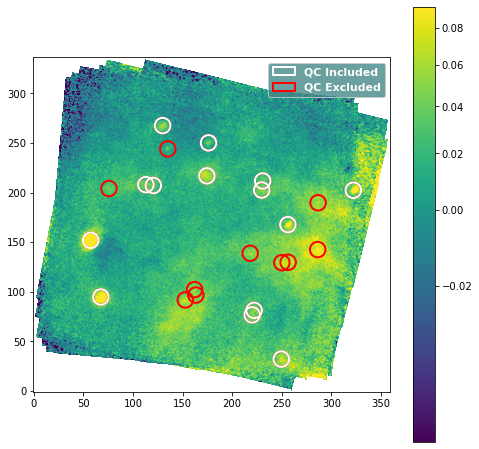

In [57]:
#now let's examine which sources didn't pass the cuts - overplot on the image to see if it looks first order reasonable

#get source coordinates for the snr cut table
cutsc=mtcut['sky_centroid'] 

#Compare which sources are included/excluded
source_aperture =SkyCircularAperture(cutsc, r=6*u.arcsec)

#convert to pixel coords for plotting
pix_aperture_source = source_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)


ap_patches = pix_aperture.plot(color='red', lw=2,
                           label='QC Excluded')
ap_patches_new = pix_aperture_source.plot(color='white', lw=2,
                           label='QC Included')

handles = (ap_patches_new[0],ap_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
          handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

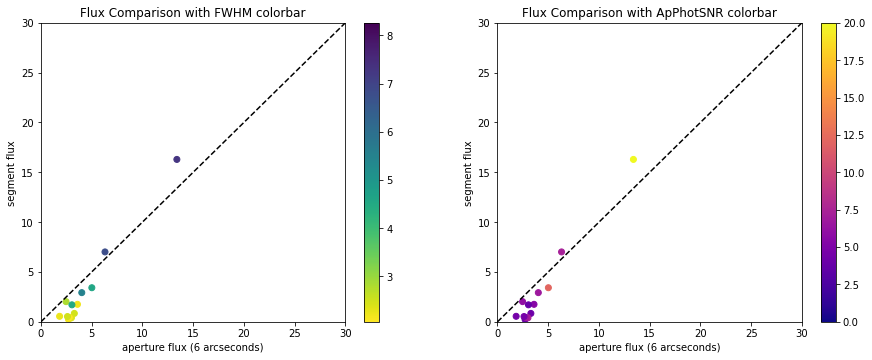

In [58]:
#a few diagnostic plots to examine segment and aperture fluxes
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with FWHM colorbar')
p1=ax1.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['fwhm']*0.768, cmap='viridis_r')
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (6 arcseconds)')
ax1.set_ylabel('segment flux')
ax1.set_xlim(0,30)
ax1.set_ylim(0,30)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=20)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (6 arcseconds)')
ax2.set_ylabel('segment flux')
ax2.set_xlim(0,30)
ax2.set_ylim(0,30)


plt.show()

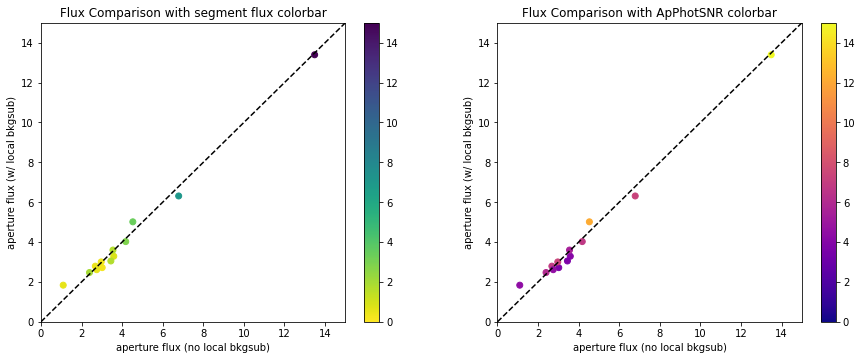

In [59]:
#a few diagnostic plots to examine background contributions to aperture flux
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with segment flux colorbar')
p1=ax1.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['segment_flux'], cmap='viridis_r',vmin=0,vmax=15)
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (no local bkgsub)')
ax1.set_ylabel('aperture flux (w/ local bkgsub)')
ax1.set_xlim(0,15)
ax1.set_ylim(0,15)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=15)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (no local bkgsub)')
ax2.set_ylabel('aperture flux (w/ local bkgsub)')
ax2.set_xlim(0,15)
ax2.set_ylim(0,15)


plt.show()

In [60]:
#write out the resulting table to file
ascii.write(mtcut, field+'_25um_cat_qcuts.dat', overwrite=True)